<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 RVI testing J.b 2025



In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features
import geopandas as gpd

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc

# Other tools
from scipy.ndimage import uniform_filter, variance
from PIL import Image
import odc
from odc.stac import stac_load

from ipyleaflet import basemaps, basemap_to_tiles
from odc.ui import select_on_a_map

import odc.geo.xr  # noqa: F401

from utils import dualpol_indices

## Define the analysis region and load the data

In [2]:
# Set study area name for outputs
study_area = "se-asia"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(12, 120), zoom=4)
#geom

Map(center=[12, 120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [3]:
#Define Time  
time_of_interest = ('2020-01-01', '2020-08-31')

In [8]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [9]:
# We will only load a specific orbit path (descending or ascending)
search = catalog.search(
    collections=["sentinel-1-rtc"], 
    intersects=geom, 
    datetime=time_of_interest,
    query={"sat:orbit_state": {"eq": "descending"}}
)

In [10]:
items = list(search.get_all_items()) # This produces a list of scene IDs

In [11]:
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 20


Next, we'll load the data into an XARRAY and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands (VV, VH). We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees and we have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. 

In [12]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
# The best resolution for Sentinel-1 is 10-meters
# Use 100-meters for rapid review of the datasets

resolution = 20  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [13]:
# Load the data using Open Data Cube

data = stac_load(
    items,bands=["vv", "vh"], 
    patch_url=pc.sign, 
    geopolygon=geom, 
    crs="EPSG:4326", 
    resolution=scale, 
    groupby="solar_day"
)

In [14]:
#data

In [15]:
# Adjust band data for improved RGB output
vv_new = data.vv / 6
vh_new = data.vh / 1
data['vv_new'] = vv_new
data['vh_new'] = vh_new
data['vvvh_new'] = (vv_new / vh_new) / 30

In [16]:
data

<xarray.Dataset> Size: 193MB
Dimensions:      (latitude: 596, longitude: 808, time: 20)
Coordinates:
  * latitude     (latitude) float64 5kB -17.4 -17.4 -17.4 ... -17.51 -17.51
  * longitude    (longitude) float64 6kB 168.3 168.3 168.3 ... 168.4 168.4 168.4
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 160B 2020-01-05T18:21:02.671902 ... 20...
Data variables:
    vv           (time, latitude, longitude) float32 39MB 0.07906 ... 0.01918
    vh           (time, latitude, longitude) float32 39MB 0.005901 ... 0.004601
    vv_new       (time, latitude, longitude) float32 39MB 0.01318 ... 0.003196
    vh_new       (time, latitude, longitude) float32 39MB 0.005901 ... 0.004601
    vvvh_new     (time, latitude, longitude) float32 39MB 0.07443 ... 0.02315

### View RGB (false color) images from the time series

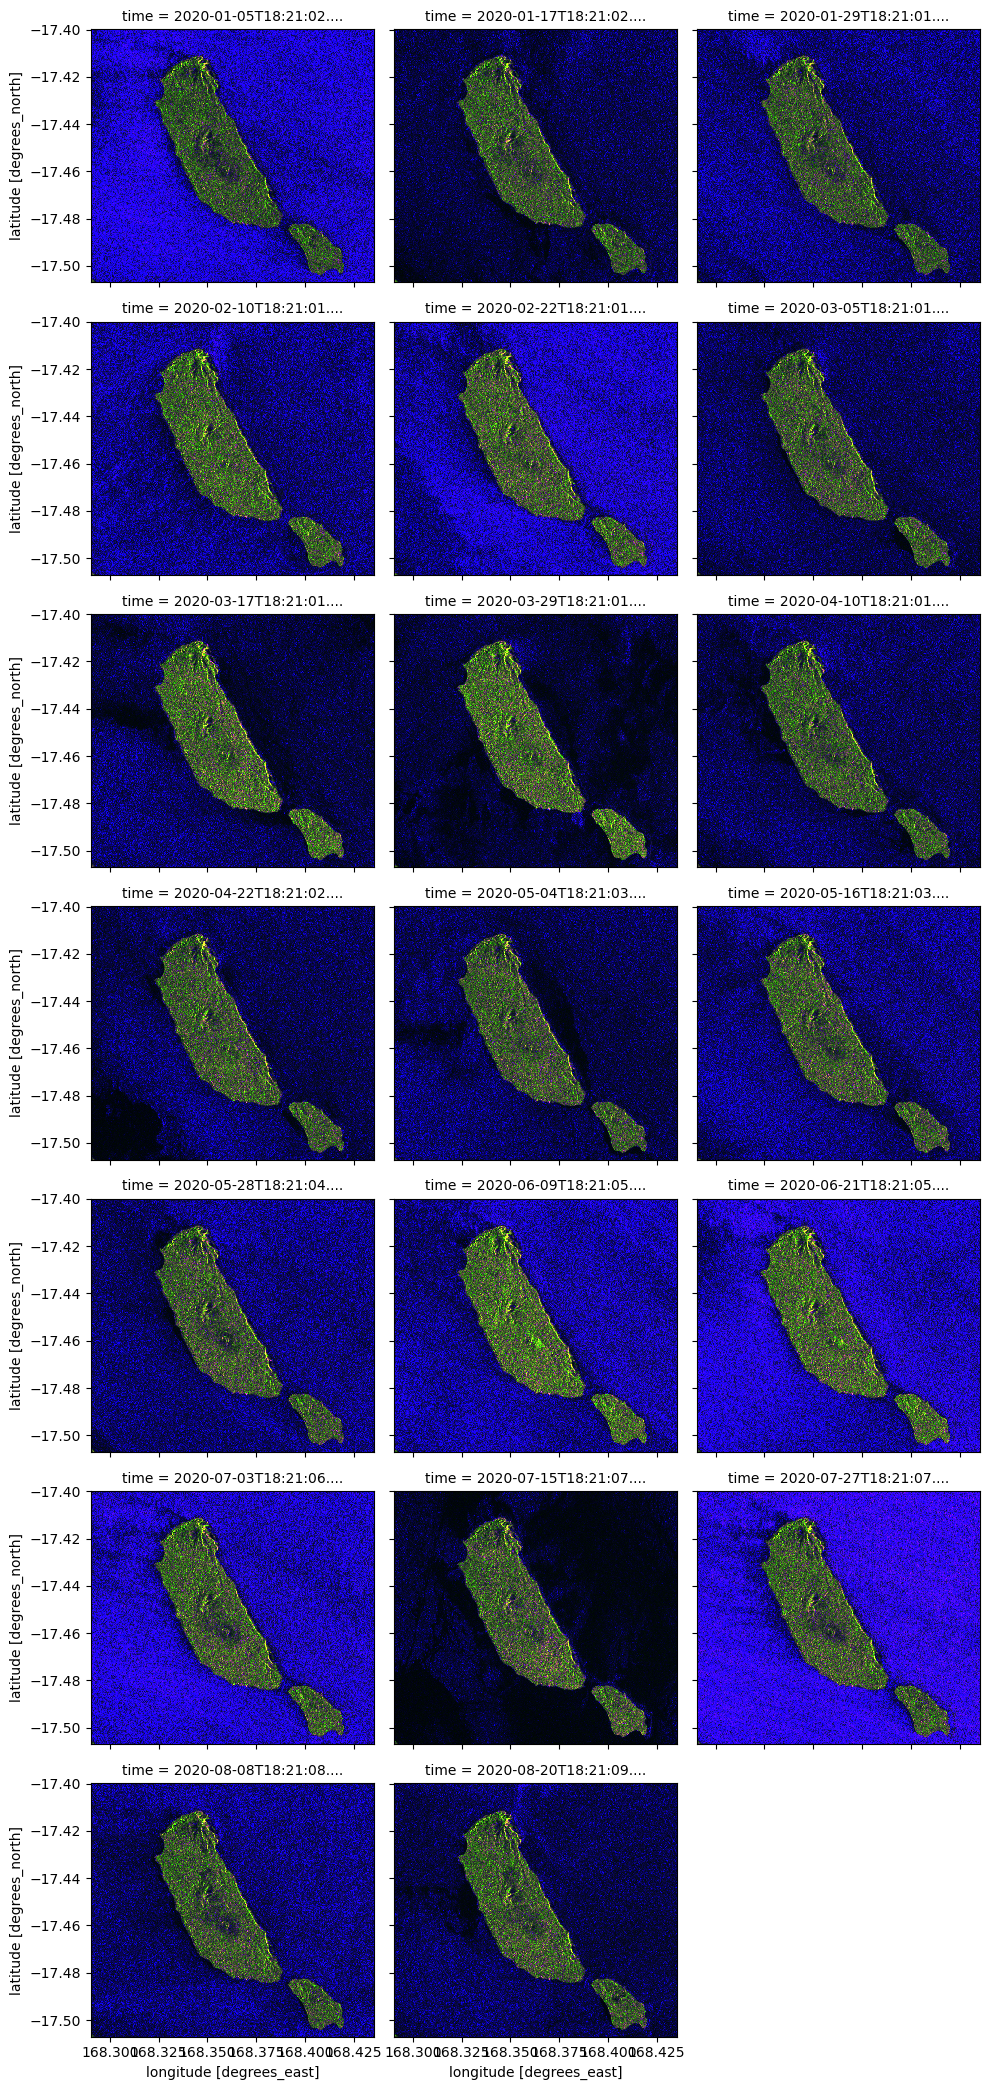

In [17]:
# Plot small images for the entire dataset
# CAUTION ... This can produce lots of images in a large time series

plot_data = data[["vv_new","vh_new","vvvh_new"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=3, vmin=0.0, vmax=0.15)
plt.show()

In [18]:
# Select a time slice to view a single scene
# See the XARRAY dimensions above for the number of time slices (starts at 0)
slice = 0

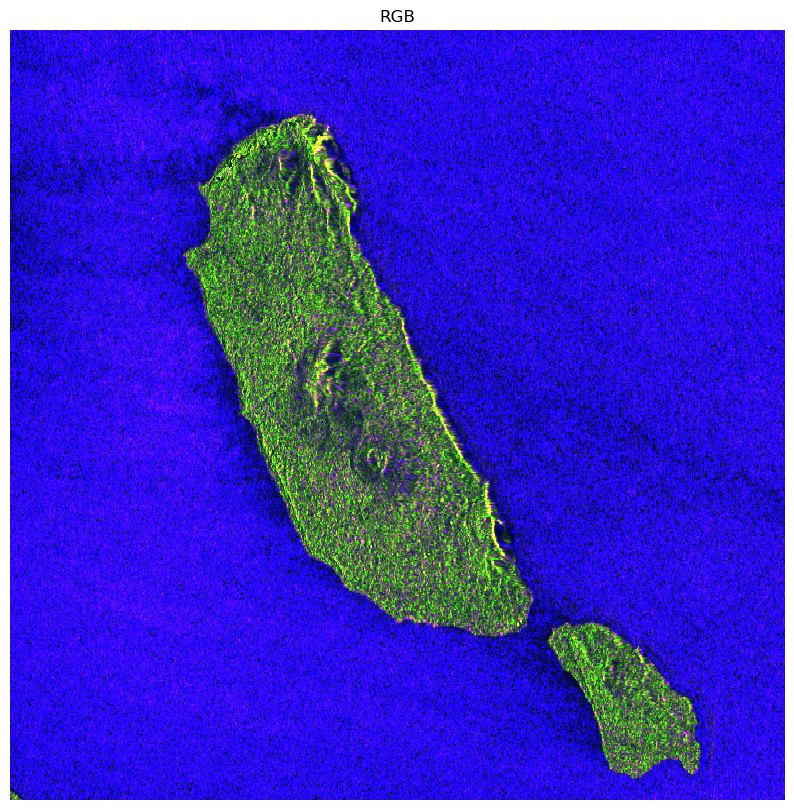

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
plot_data.isel(time=slice).plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.1)
plt.title("RGB")
plt.axis('off')
plt.show()

## Speckle Filtering using a Lee Filter
Radar data is often "grainy" in appearance and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common Lee filter to average the pixels surrounding any given pixel.

In [61]:
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    da_notime = da.squeeze()
    img = da_notime.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray, flipping the Y axis
    output = xr.DataArray(img_output, dims=da_notime.dims, coords=da_notime.coords)
    
    return output

In [62]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = np.isfinite(data)
masked = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
# Select the filter size at the end of each line ... use odd numbers (3,5,7, etc).
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=5)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=5)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv)
data['filtered_vh'] = data.filtered_vh.where(valid.vh)

## RVI 

In [20]:
ds = data

In [21]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = dualpol_indices(ds, index="RVI")

In [22]:
ds

<xarray.Dataset> Size: 231MB
Dimensions:      (latitude: 596, longitude: 808, time: 20)
Coordinates:
  * latitude     (latitude) float64 5kB -17.4 -17.4 -17.4 ... -17.51 -17.51
  * longitude    (longitude) float64 6kB 168.3 168.3 168.3 ... 168.4 168.4 168.4
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 160B 2020-01-05T18:21:02.671902 ... 20...
Data variables:
    vv           (time, latitude, longitude) float32 39MB 0.07906 ... 0.01918
    vh           (time, latitude, longitude) float32 39MB 0.005901 ... 0.004601
    vv_new       (time, latitude, longitude) float32 39MB 0.01318 ... 0.003196
    vh_new       (time, latitude, longitude) float32 39MB 0.005901 ... 0.004601
    vvvh_new     (time, latitude, longitude) float32 39MB 0.07443 ... 0.02315
    RVI          (time, latitude, longitude) float32 39MB 0.2778 ... 0.7741

Text(0.5, 1.0, 'Zonal mean of radar vegetation index timeseries')

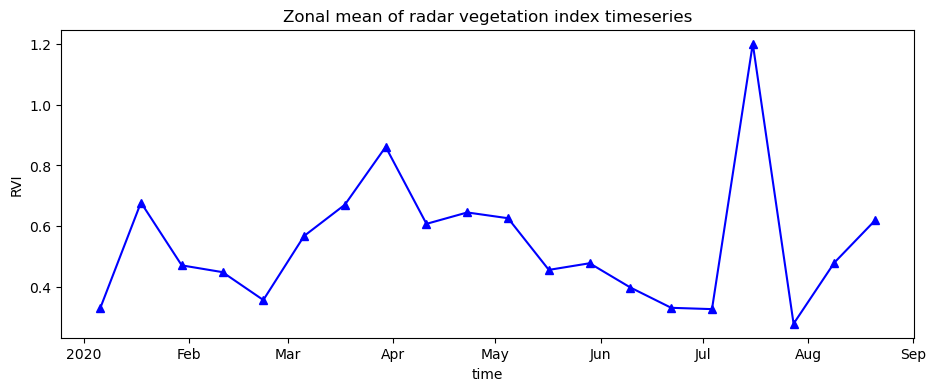

In [23]:
ds.RVI.mean(dim=["latitude", "longitude"]).plot.line("b-^", figsize=(11, 4))
plt.title("Zonal mean of radar vegetation index timeseries")


Text(0.5, 1.0, 'Mean RVI Over Time')

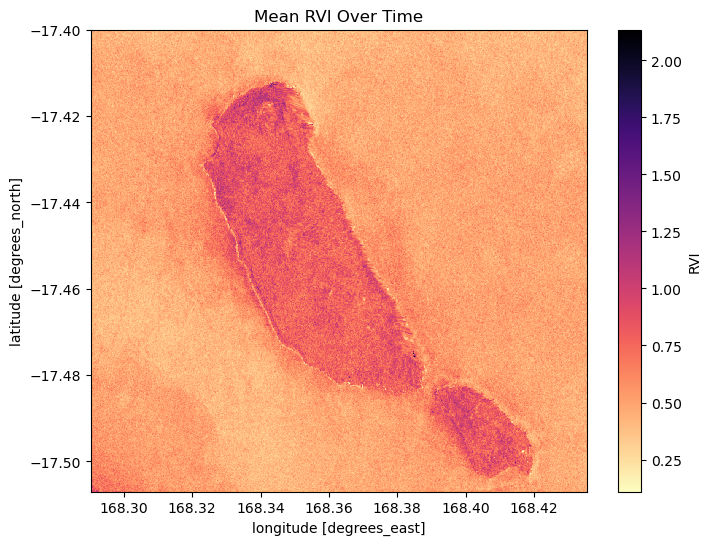

In [24]:
#display RVI

ds.RVI.mean(dim="time").plot(cmap="magma_r", figsize=(8, 6))
plt.title("Mean RVI Over Time")

In [25]:
YlGn

NameError: name 'YlGn' is not defined